# 🎨 Architectural Pattern Analysis Notebook

**Updated to use `ArchitecturalPatternAnalyzer` from `src/architectural_pattern_analyzer.py`**

This notebook demonstrates how to use the new pattern analysis functionality to:
- Fetch and aggregate Azure resource relationships
- Build NetworkX graphs from the aggregated data
- Detect common architectural patterns (Web Apps, VM Workloads, Container Platforms, etc.)
- Generate beautiful visualizations with pattern overlays

The same visualizations are produced, but now using our reusable `ArchitecturalPatternAnalyzer` class!

# Explore Entities from Azure Tenant Scan

This notebook queries the Neo4j database to show all entities (resources) discovered during the Azure tenant scan.

## Prerequisites
- Neo4j must be running (default: bolt://localhost:7687)
- You must have completed an `azure-tenant-grapher scan`

In [1]:
# Import required libraries
import os

import pandas as pd
from IPython.display import Markdown, display
from neo4j import GraphDatabase

In [2]:
# Connect to Neo4j
uri = "bolt://localhost:7687"
auth = ("neo4j", "neo4j123")  # Update if you changed the password

driver = GraphDatabase.driver(uri, auth=auth)
print("✅ Connected to Neo4j")

✅ Connected to Neo4j


## 1. Get All Entity Types (Node Labels)

In [3]:
with driver.session() as session:
    # Get all node labels (entity types)
    result = session.run("CALL db.labels()")
    labels = [record[0] for record in result]

    display(Markdown("### 📊 Entity Types Discovered in Your Tenant"))
    display(Markdown("---"))

    entity_summary = []
    total_entities = 0

    for label in sorted(labels):
        count_result = session.run(f"MATCH (n:`{label}`) RETURN count(n) as count")
        count = count_result.single()["count"]
        total_entities += count
        entity_summary.append({"Entity Type": label, "Count": count})

    # Display as DataFrame
    df = pd.DataFrame(entity_summary)
    display(df)

    display(Markdown(f"\n### 📈 **Total Entities: {total_entities}**"))

### 📊 Entity Types Discovered in Your Tenant

---

,Entity Type,Count
0,DNSZone,11
1,IdentityGroup,12
2,Original,3459
3,PrivateEndpoint,74
4,Region,16
5,Resource,6496
6,ResourceGroup,232
7,RoleAssignment,1042
8,RoleDefinition,79
9,ServicePrincipal,231



### 📈 **Total Entities: 12124**

## 7. Architectural Pattern Analysis

Now let's use the `ArchitecturalPatternAnalyzer` class to analyze resource relationships and detect architectural patterns!

In [4]:
# Import required libraries for graph analysis
import sys

# Add src to path for importing our modules
sys.path.insert(0, os.path.abspath(".."))


import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import Patch, Polygon
from scipy.spatial import ConvexHull

from src.architectural_pattern_analyzer import ArchitecturalPatternAnalyzer

print("✅ Graph libraries imported")
print("✅ ArchitecturalPatternAnalyzer imported from src")

✅ Graph libraries imported
✅ ArchitecturalPatternAnalyzer imported from src


In [5]:
# Step 1: Use ArchitecturalPatternAnalyzer to fetch and aggregate relationships
analyzer = ArchitecturalPatternAnalyzer(uri, auth[0], auth[1])
analyzer.connect()

# Fetch all relationships
all_relationships = analyzer.fetch_all_relationships()

# Aggregate by resource type
aggregated_relationships = analyzer.aggregate_relationships(all_relationships)

print(f"✅ Loaded {len(all_relationships)} relationships from graph")
print(f"✅ Aggregated into {len(aggregated_relationships)} unique patterns")

✅ Loaded 16019 relationships from graph
✅ Aggregated into 354 unique patterns


In [6]:
# Step 2: Display aggregated relationship patterns
display(Markdown("### 🔗 Top 100 Aggregated Relationship Patterns"))
print(f"Total unique patterns: {len(aggregated_relationships)}\n")
print("Top 100 by frequency:")
for i, rel in enumerate(aggregated_relationships[:100], 1):
    same_type = " [SAME TYPE]" if rel["source_type"] == rel["target_type"] else ""
    print(
        f"{i:3d}. {rel['source_type']:35s} -[{rel['rel_type']:20s}]-> {rel['target_type']:35s} : {rel['frequency']:5d}{same_type}"
    )

### 🔗 Top 100 Aggregated Relationship Patterns

Total unique patterns: 354

Top 100 by frequency:
  1. roleAssignments                     -[SCAN_SOURCE_NODE    ]-> roleAssignments                     :  1042 [SAME TYPE]
  2. Subscription                        -[CONTAINS            ]-> roleAssignments                     :  1042
  3. roleAssignments                     -[CREATED_BY          ]-> User                                :  1029
  4. ResourceGroup                       -[CONTAINS            ]-> roleAssignments                     :   708
  5. roleAssignments                     -[ASSIGNED_TO         ]-> ServicePrincipal                    :   574
  6. roleAssignments                     -[ASSIGNED_TO         ]-> User                                :   427
  7. virtualNetworks                     -[CONTAINS            ]-> subnets                             :   397
  8. virtualMachineScaleSets             -[TAGGED_WITH         ]-> Tag                                 :   333
  9. Subscription                        -[CONTAIN

In [7]:
# Step 3: Build NetworkX graph using the analyzer
G, resource_type_counts, edge_counts = analyzer.build_networkx_graph(
    aggregated_relationships
)

print("✅ Graph constructed from aggregated data:")
print(f"   - Nodes (resource types): {G.number_of_nodes()}")
print(f"   - Edges (relationship patterns): {G.number_of_edges()}")
print(f"   - Unique source->target patterns: {len(edge_counts)}")
print("\nTop 20 resource types by connection frequency:")
for i, (rtype, count) in enumerate(
    sorted(resource_type_counts.items(), key=lambda x: x[1], reverse=True)[:20], 1
):
    print(f"  {i:2d}. {rtype:40s} : {count:6d}")

✅ Graph constructed from aggregated data:
   - Nodes (resource types): 85
   - Edges (relationship patterns): 354
   - Unique source->target patterns: 353

Top 20 resource types by connection frequency:
   1. roleAssignments                          :   5905
   2. Subscription                             :   3489
   3. ResourceGroup                            :   3155
   4. Region                                   :   2215
   5. Tag                                      :   1464
   6. User                                     :   1457
   7. networkInterfaces                        :   1073
   8. networkSecurityGroups                    :   1061
   9. virtualNetworks                          :    942
  10. subnets                                  :    801
  11. publicIPAddresses                        :    798
  12. disks                                    :    662
  13. virtualMachines                          :    637
  14. userAssignedIdentities                   :    622
  15. storage

📐 Detected 10 architectural patterns


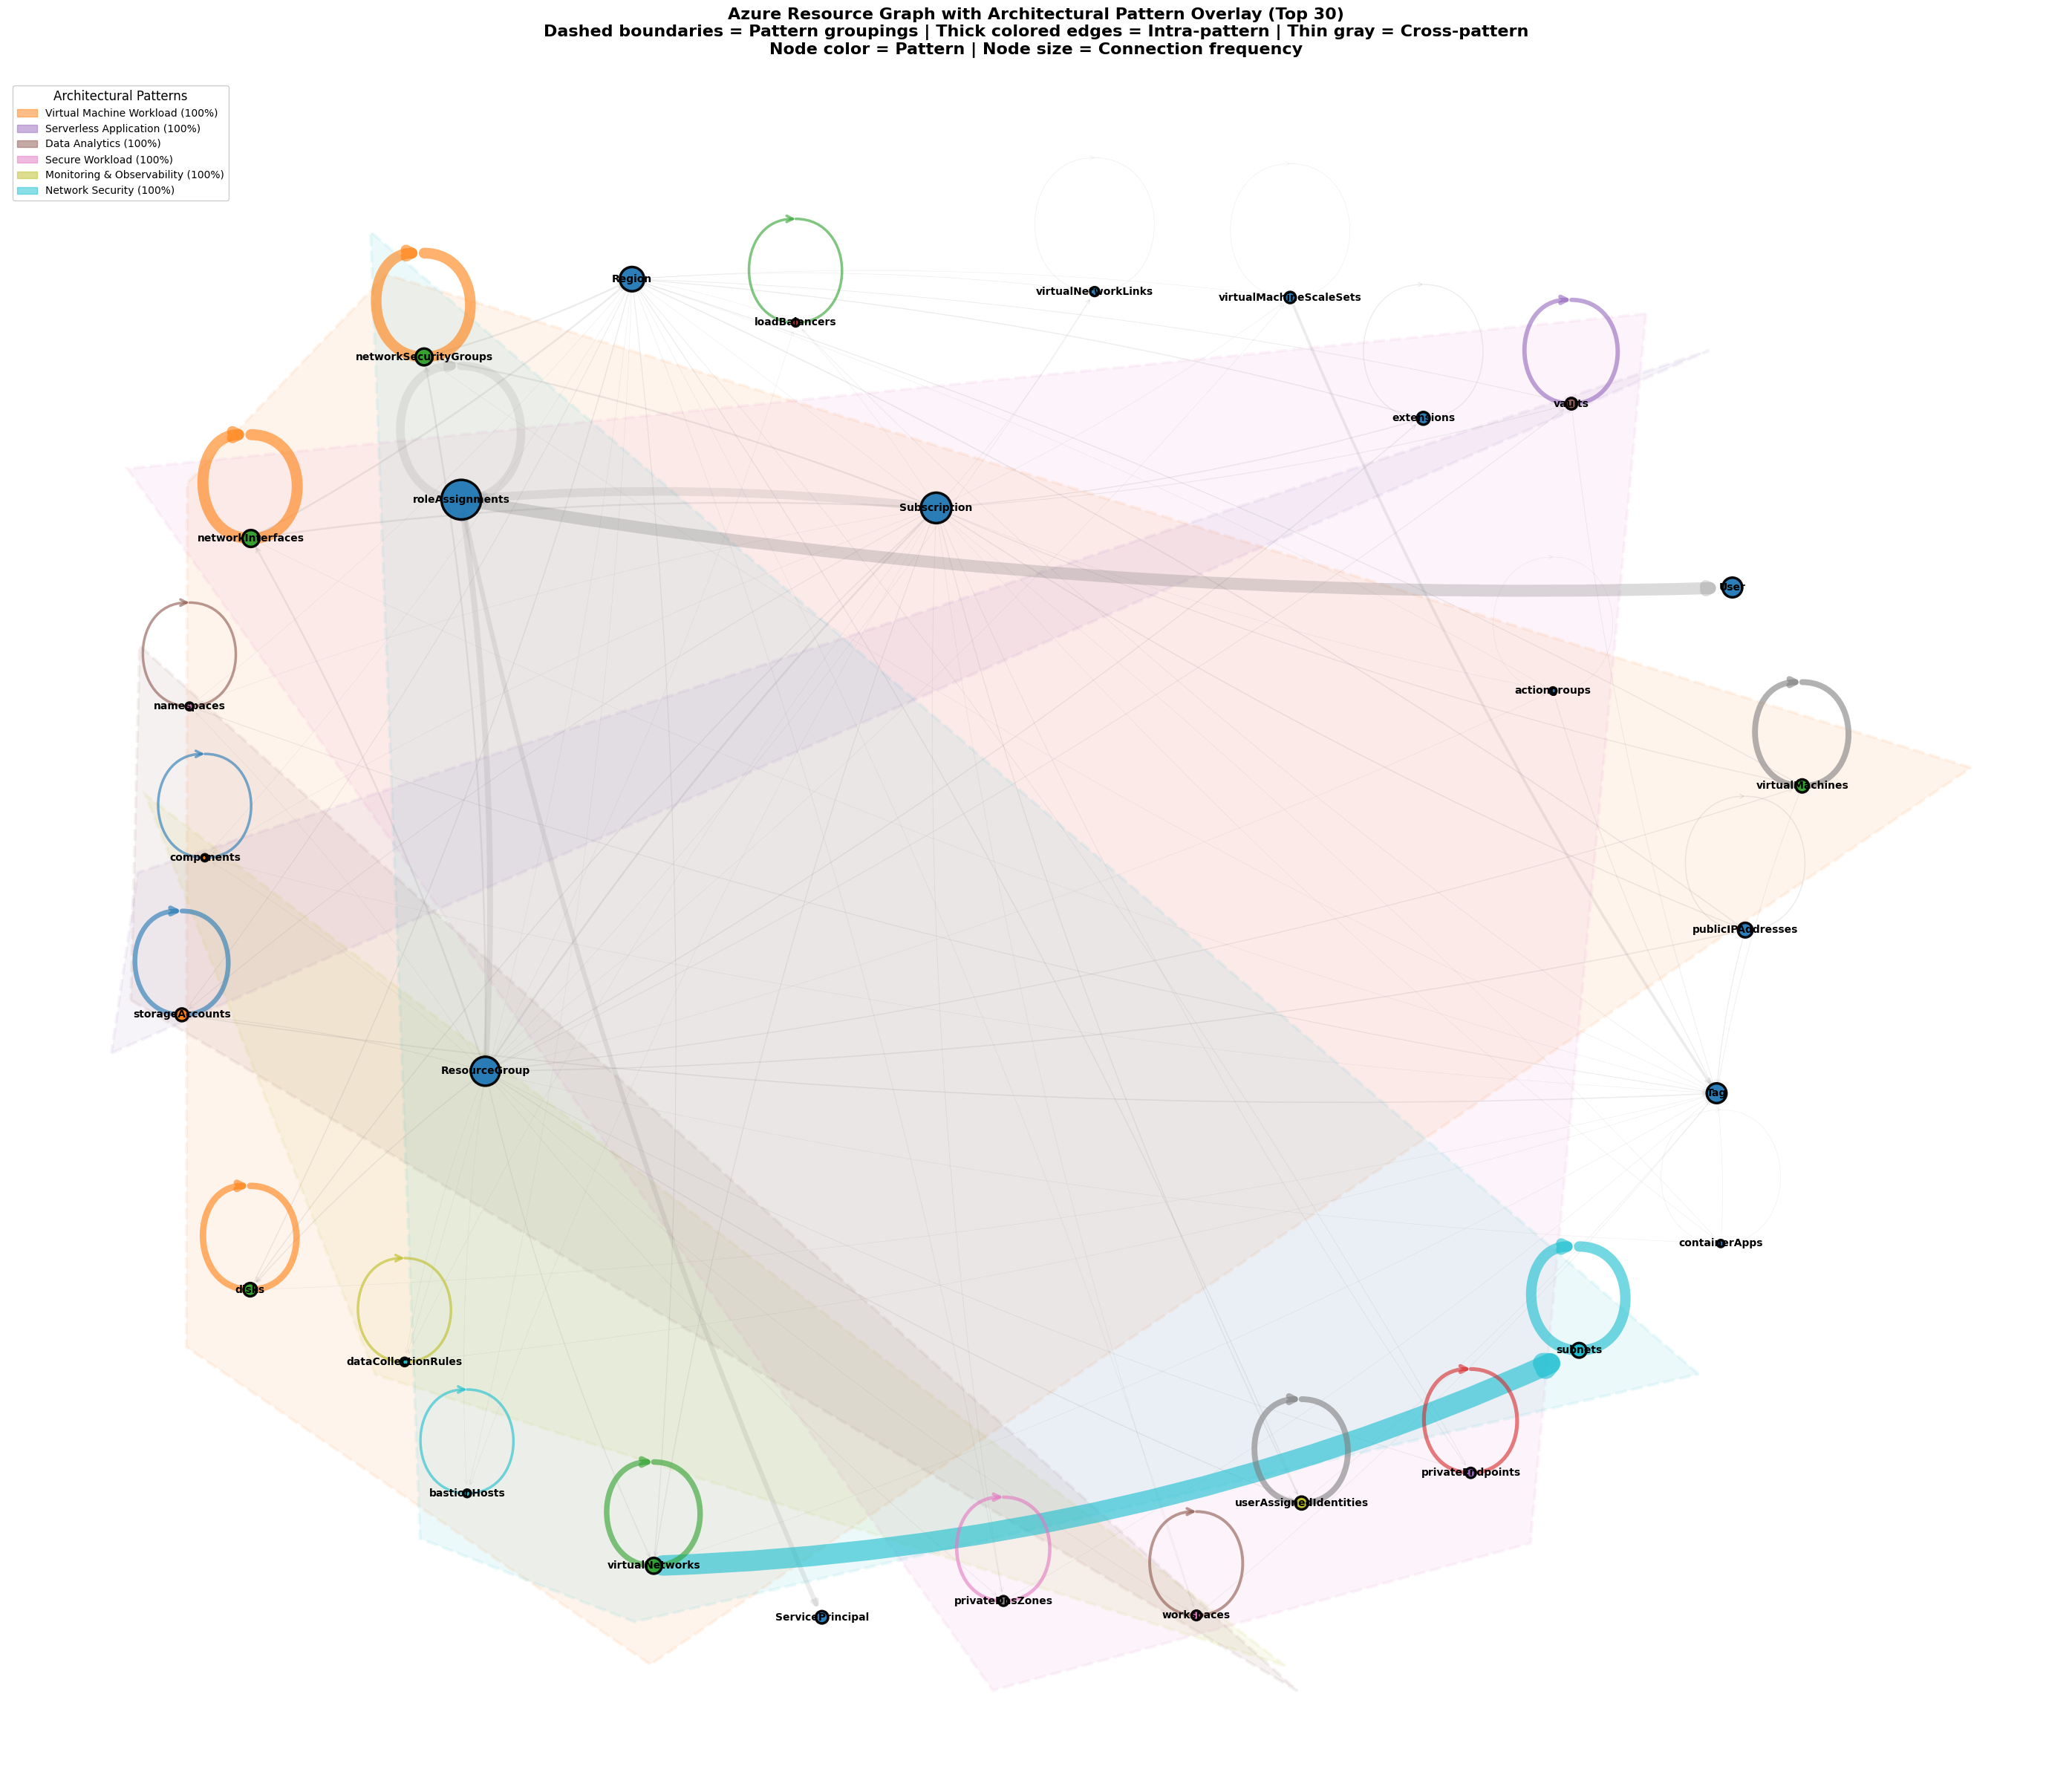


📊 Visualization:
   - Resource types: 30
   - Intra-pattern edges: 18 (colored)
   - Cross-pattern edges: 97 (gray)
   - Patterns detected: 10


In [8]:
# Step 4: Detect architectural patterns and visualize
pattern_matches = analyzer.detect_patterns(G, resource_type_counts)

print(f"📐 Detected {len(pattern_matches)} architectural patterns")

# Filter to show only the most significant nodes
top_n_nodes = 30
top_nodes = sorted(resource_type_counts.items(), key=lambda x: x[1], reverse=True)[
    :top_n_nodes
]
top_node_names = [name for name, _ in top_nodes]

# Create subgraph with only top nodes
G_filtered = G.subgraph(top_node_names).copy()

# Compute layout
pos = nx.spring_layout(G_filtered, k=3, iterations=50, seed=42)

# Assign patterns to nodes
node_pattern_map = {}
node_colors = []

for node in G_filtered.nodes():
    node_patterns = []
    for pattern_name, match in pattern_matches.items():
        if node in match["matched_resources"]:
            node_patterns.append(pattern_name)
    node_pattern_map[node] = node_patterns

    if node_patterns:
        best_pattern = max(
            node_patterns, key=lambda p: pattern_matches[p]["completeness"]
        )
        pattern_index = list(pattern_matches.keys()).index(best_pattern)
        node_colors.append(pattern_index)
    else:
        node_colors.append(-1)

# Calculate sizes and edge properties
node_sizes = [G_filtered.nodes[node]["count"] / 4 for node in G_filtered.nodes()]

# Separate pattern vs cross-pattern edges
pattern_edges = []
cross_pattern_edges = []
pattern_edge_widths = []
cross_pattern_edge_widths = []
pattern_edge_colors = []

for u, v, data in G_filtered.edges(data=True):
    freq = edge_counts.get((u, v), 0)
    edge_width = max(1, freq / 50)

    u_patterns = set(node_pattern_map.get(u, []))
    v_patterns = set(node_pattern_map.get(v, []))
    shared_patterns = u_patterns.intersection(v_patterns)

    if shared_patterns:
        pattern_edges.append((u, v))
        pattern_edge_widths.append(edge_width * 2.5)
        shared_pattern = list(shared_patterns)[0]
        pattern_index = list(pattern_matches.keys()).index(shared_pattern)
        pattern_edge_colors.append(pattern_index)
    else:
        cross_pattern_edges.append((u, v))
        cross_pattern_edge_widths.append(edge_width * 0.4)

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(28, 24))

# Draw pattern boundaries
cmap = plt.cm.tab10
pattern_legend = []

for pattern_idx, (pattern_name, match) in enumerate(pattern_matches.items()):
    pattern_nodes = [n for n in match["matched_resources"] if n in G_filtered.nodes()]

    if len(pattern_nodes) >= 3:
        try:
            points = np.array([[pos[node][0], pos[node][1]] for node in pattern_nodes])
            center = points.mean(axis=0)
            points_expanded = center + (points - center) * 1.15
            hull = ConvexHull(points_expanded)
            hull_points = points_expanded[hull.vertices]

            color = cmap(pattern_idx / len(pattern_matches))
            polygon = Polygon(
                hull_points,
                facecolor=color,
                alpha=0.08,
                edgecolor=color,
                linewidth=3,
                linestyle="--",
                zorder=1,
            )
            ax.add_patch(polygon)

            pattern_legend.append(
                Patch(
                    facecolor=color,
                    edgecolor=color,
                    label=f"{pattern_name} ({match['completeness']:.0f}%)",
                    alpha=0.5,
                )
            )
        except:
            pass

# Draw cross-pattern edges first (gray background)
if cross_pattern_edges:
    nx.draw_networkx_edges(
        G_filtered,
        pos,
        edgelist=cross_pattern_edges,
        width=cross_pattern_edge_widths,
        alpha=0.15,
        edge_color="gray",
        arrows=True,
        arrowsize=10,
        arrowstyle="->",
        connectionstyle="arc3,rad=0.05",
        ax=ax,
    )

# Draw pattern edges (colored by pattern)
if pattern_edges:
    for idx, (u, v) in enumerate(pattern_edges):
        edge_color = cmap(pattern_edge_colors[idx] / len(pattern_matches))
        nx.draw_networkx_edges(
            G_filtered,
            pos,
            edgelist=[(u, v)],
            width=pattern_edge_widths[idx],
            alpha=0.6,
            edge_color=[edge_color],
            arrows=True,
            arrowsize=15,
            arrowstyle="->",
            connectionstyle="arc3,rad=0.1",
            ax=ax,
        )

# Draw nodes
nx.draw_networkx_nodes(
    G_filtered,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=cmap,
    vmin=-1,
    vmax=len(pattern_matches) - 1,
    alpha=0.95,
    edgecolors="black",
    linewidths=2.5,
    ax=ax,
)

# Draw labels
nx.draw_networkx_labels(G_filtered, pos, font_size=10, font_weight="bold", ax=ax)

# Add legend
if pattern_legend:
    ax.legend(
        handles=pattern_legend,
        loc="upper left",
        fontsize=10,
        framealpha=0.95,
        title="Architectural Patterns",
        title_fontsize=12,
    )

ax.set_title(
    f"Azure Resource Graph with Architectural Pattern Overlay (Top {top_n_nodes})\n"
    + "Dashed boundaries = Pattern groupings | Thick colored edges = Intra-pattern | "
    + "Thin gray = Cross-pattern\n"
    + "Node color = Pattern | Node size = Connection frequency",
    fontsize=16,
    fontweight="bold",
    pad=25,
)
ax.axis("off")
plt.tight_layout()
plt.show()

print("\n📊 Visualization:")
print(f"   - Resource types: {len(G_filtered.nodes())}")
print(f"   - Intra-pattern edges: {len(pattern_edges)} (colored)")
print(f"   - Cross-pattern edges: {len(cross_pattern_edges)} (gray)")
print(f"   - Patterns detected: {len(pattern_matches)}")

In [9]:
# Step 5: Export aggregated graph data to JSON using the analyzer
from pathlib import Path

output_file = Path("/tmp/azure_resource_graph_aggregated.json")
analyzer.export_graph_data(G, resource_type_counts, output_file, len(all_relationships))

print(f"✅ Aggregated graph data exported to: {output_file}")
print(f"   - {G.number_of_nodes()} unique resource types")
print(f"   - {G.number_of_edges()} unique relationship patterns")
print(f"   - Aggregated from {len(all_relationships):,} individual relationships")
print(
    "\nYou can use this JSON file with visualization tools like D3.js, Cytoscape, or Gephi"
)

✅ Aggregated graph data exported to: /tmp/azure_resource_graph_aggregated.json
   - 85 unique resource types
   - 354 unique relationship patterns
   - Aggregated from 16,019 individual relationships

You can use this JSON file with visualization tools like D3.js, Cytoscape, or Gephi


In [10]:
# Close both the driver and analyzer connections
driver.close()
analyzer.close()
print("✅ Connections closed")

✅ Connections closed
